In [4]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import ctypes
import numba as nb
from matplotlib import pyplot as plt
from IPython.display import Image

***
## Problem 1

In this problem, the main goal is to realise what it means for a random number generator to be not good. We use the built in C **rand()** function to see the effects

In [60]:
# Random number generator (windows)
# ----------------------------------------------------------------------------

mylib=ctypes.cdll.LoadLibrary("msvcrt") 
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int

@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec


n=300000000
vec=get_rands(n*3)
#vv=vec&(2**16-1)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e3
vv2=vv[vmax<maxval,:]

f=open('rand_points2.txt','w')
for i in range(vv2.shape[0]):
    myline=repr(vv2[i,0])+' '+repr(vv2[i,1])+' '+ repr(vv2[i,2])+'\n'
    f.write(myline)
f.close()

# Note: The rand function of C is limited to max of 32767, not sure why the linux
# one goes to 2^31. 

# ----------------------------------------------------------------------------

The below data was generated by using **msvcrt** library, the rand function has an 
upper bound of 32767 and I sample only those points that are below 1000 in order to 
indirectly zoom into the generated points.

In [ ]:
# ----------------------------------------------------------------------------
# PROBLEM 1
# ----------------------------------------------------------------------------

f1 = np.loadtxt('rand_points.txt',dtype = 'float')    	# The original one which was provided
f = np.loadtxt('rand_points2.txt',dtype = 'float')	# The one I generated

# Please refer to the image included in folder ps-6 'C_RNG_fail(from generated data)'

# The below data was generated by using msvcrt library, the rand function has an 
# upper bound of 32767 and I sample only those points that are below 1000 in order to 
# indirectly zoom into the generated points.

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(f[:,0],f[:,1],f[:,2],marker='o')
plt.title('C random number gen. (by modifying the wrap-code)')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

Following is what the data looks like when plotted in a 3d plot.

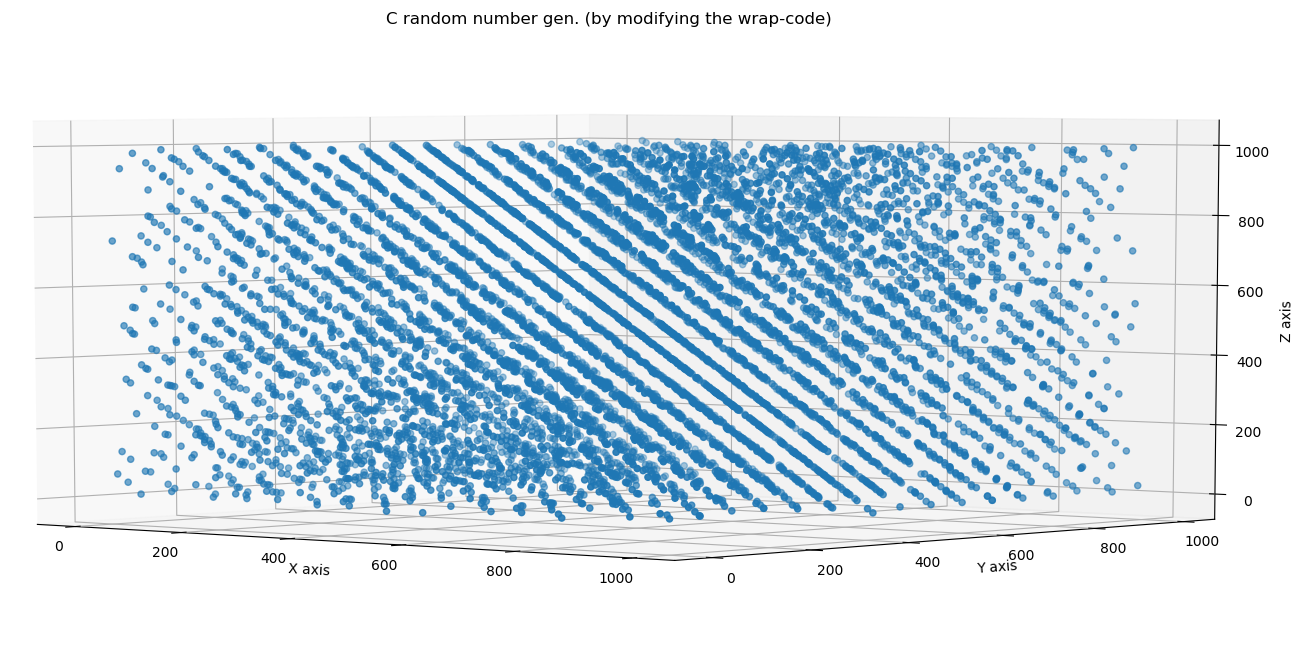

In [64]:
Image(filename = "C_RNG_fail(from generated data).png", width = 800, height = 400)

Viewed from this angle its clear that the data isnt completely random. They seem to be arranged in sets of parallel planes which could be due to the way they are sampled by the generator.

Following plot is for the data that was provided, although these seem to be sampled on larger scale they still show the same plane-pattern as that of the data I generated

In [ ]:
# Following plot is for the data that was provided, although these seem to be sampled on larger scale
# they still show the same plane-pattern as that of the data I generated

# Please refer to the image included in folder ps-6 'C_RNG_fail(from given data)'
# I count about 33-35 planes

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(f1[:,0],f1[:,1],f1[:,2],marker='o')
plt.title('C random number gen. (given data)')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()
#plt.close()

# Apart from these, at certain viewing angles, planes also appear perpendicular to 
# previous ones indicating some correlation also between x-z also and not just x-y.

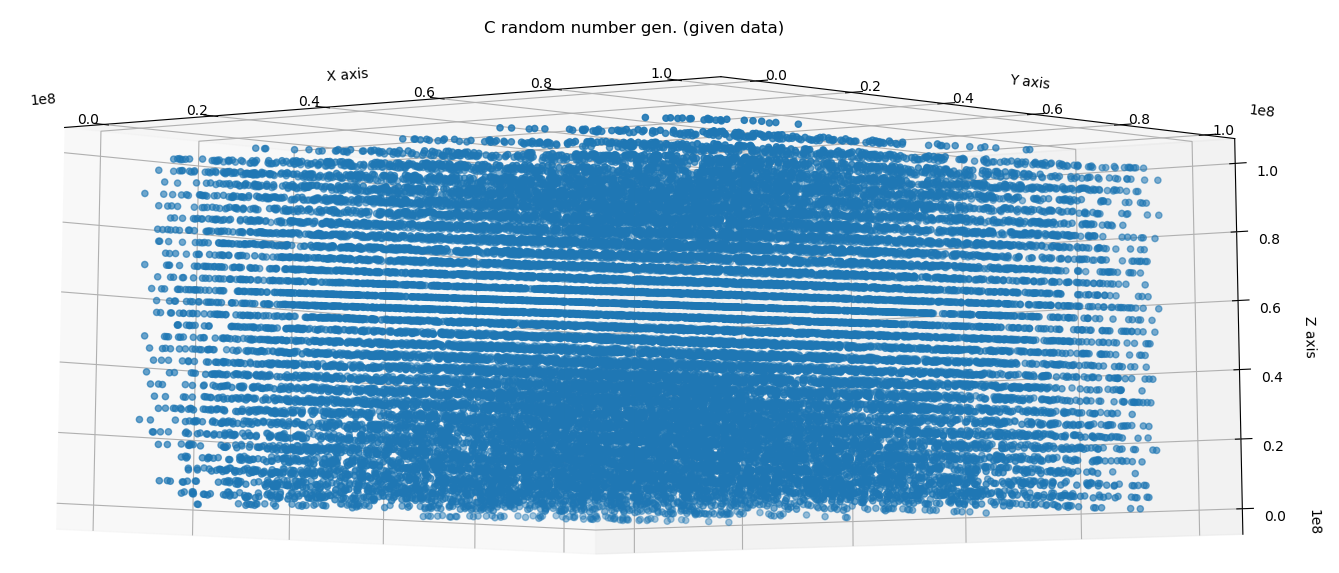

In [13]:
Image(filename = "C_RNG_fail(from given data).png", width = 800, height = 400)

Thus I verified the observation of planes (around 33-35) similar to that I observe from the number generated on my machine.

Now trying out the numpy generator :-

Here I generate a similar dataset using random numbers from numpy
but couldnt find any patterns here 

In [ ]:
# Numpy PRNG 
# ----------------------------------------------------------------------

# Here I generate a similar dataset using random numbers from numpy
# but couldnt find and pattern here 

t = np.random.randint(0, high=10**8, size=(len(f1),3))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(t[:,0],t[:,1],t[:,2],marker='o')
plt.title('Numpy random number gen.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()
#plt.close()

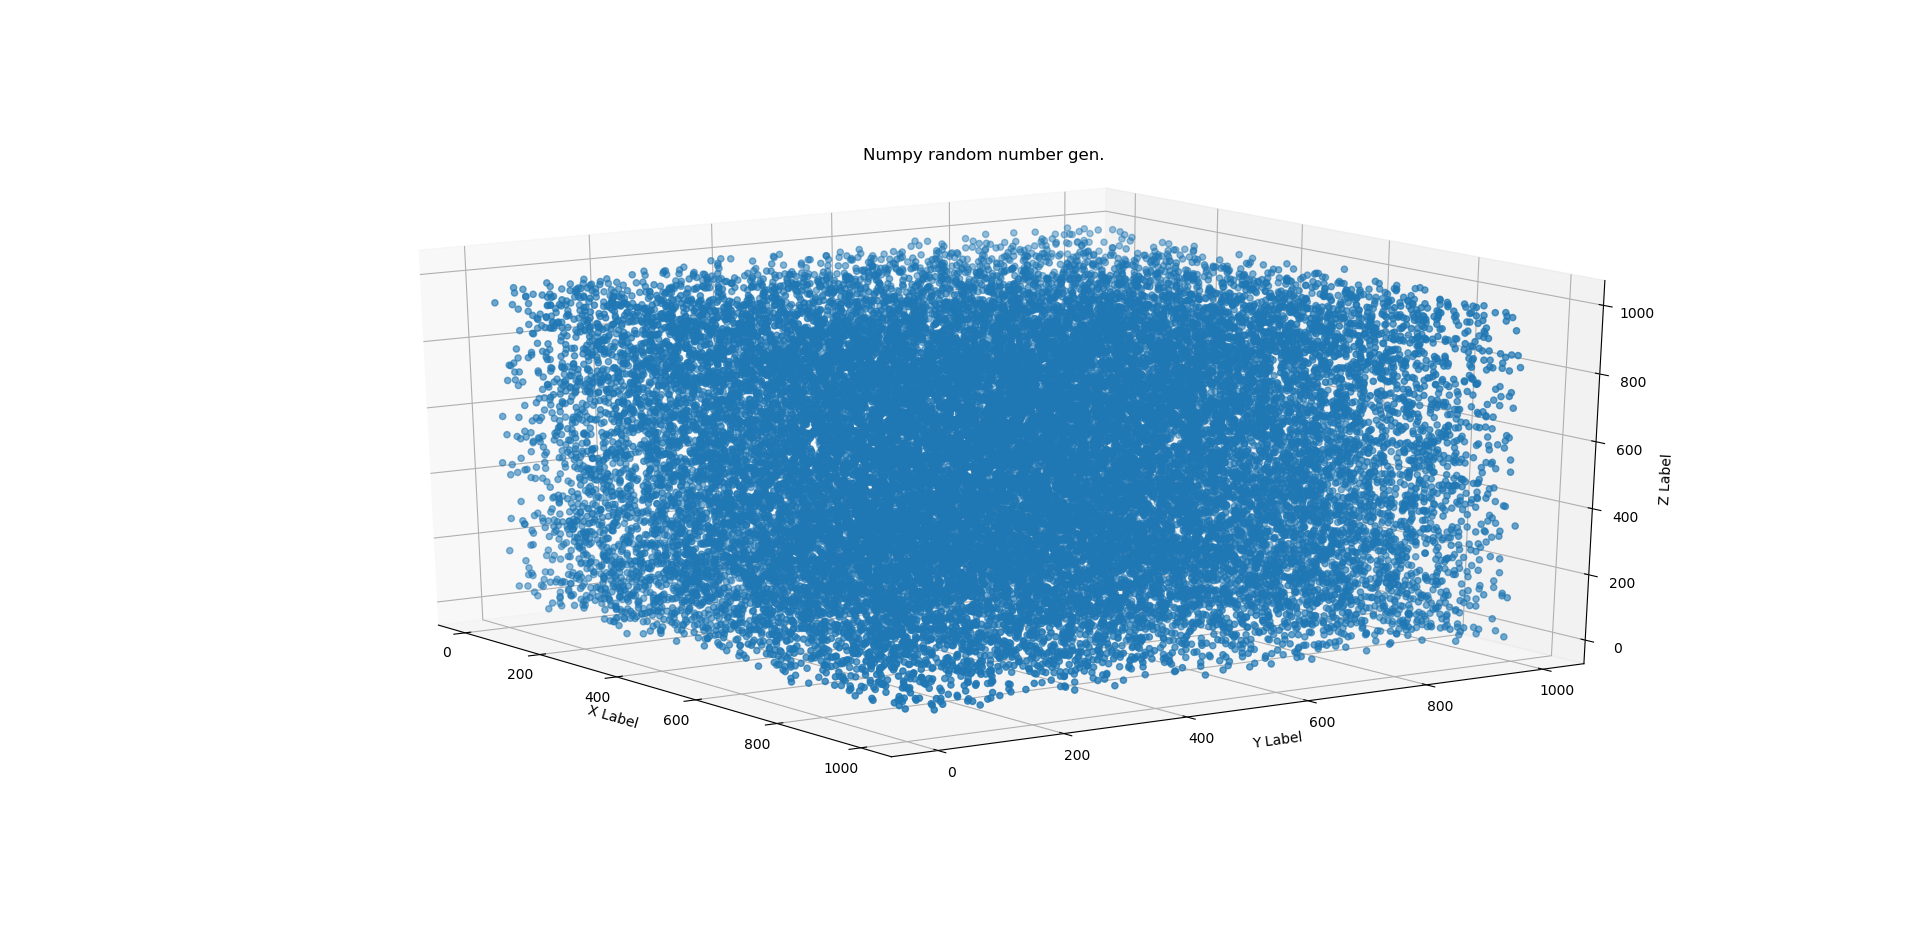

In [14]:
Image(filename = "Numpy_RNG.png", width = 800, height = 400)

***
## Problem 2

For calculating the exponential deviates
I plan on using lorentzian, the reason for this is that it is always greater 
than the exponential function exept at zero where they are equal

Reason for ruling out the gaussian was due to the fact that the tail dies out
faster than exp(-x)

Reason for ruling out powerlaw is power less than -2, i.e. -3... are less than exp(-x)
in some regions, and I didnt use 1/x^2 as the lorentzian is better choice because 
it doesnt have doesnt have a discontinuity at x=0


In [42]:
# ----------------------------------------------------------------------------
# PROBLEM 2
# ----------------------------------------------------------------------------

# I plan on using lorentzian, the reason for this is that it is always greater 
# than the exponential function exept at zero where they are equal
# Reason for ruling out the gaussian was due to the fact that the tail dies out
# faster than exp(-x)
# Reason for ruling out powerlaw is power less than -2, i.e. -3... are less than exp(-x)
# in some regions, and I didnt use 1/x^2 as the lorentzian is better choice because 
# it doesnt have doesnt have a discontinuity at x=0

def rand_lorz(n):
	x = np.random.rand(n) # from  0 to 1
	# Taking only part from 0 to +infty
	return np.tan(x*np.pi/2) # scaling x -> 0 to pi/2

Next, defining a function to accept points from sampled larentzian random variable with some probablitly based on the ratio of areas under the curves 

In [43]:
def accept_prob(x,y1,y2,a=1):# Similar to the one used in class, I originally 
	accept_prob = y1/(a*y2) # defined a in case I needed to scale the lorentzian but ended up using a=1 
	print('Max acceptance prob. : ',max(accept_prob))
	accept = np.random.rand(len(accept_prob))<accept_prob
	return x[accept]

Using these we can generate exp. deviates as follow:

In [69]:
m = 10000000
x = rand_lorz(m)
x = x[x<1000] # Limiting highest x to under 1000

y1 = np.exp(-x)
y2 = 1/(1+x*x)
a = 1.0 # scaling the envelope function
exp_dev = accept_prob(x,y1,y2,a)   # Obtaining the exponential deviants by rejection method

Max acceptance prob. :  0.999999802568895


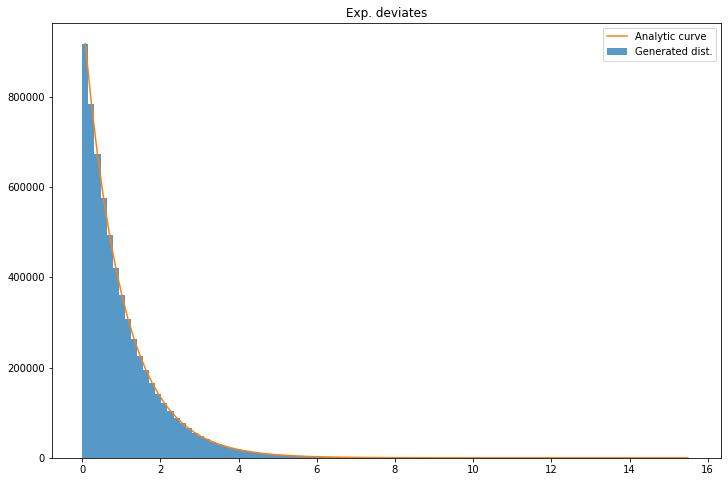

In [70]:
plt.figure(figsize = (12,8))
plt.title('Exp. deviates')
n,bins,patches = plt.hist(exp_dev,100,alpha=0.75,label='Generated dist.')
bins = np.asarray(bins)
# Shifting the b values to match hostogram bar center to function
bins2 = 0.5*(bins[:-1]+bins[1:]) 
plt.plot(bins2,n.max()*np.exp(-(bins[:-1])),label='Analytic curve')
plt.legend()
plt.show()

In [71]:
print('Efficiency: ',100*len(exp_dev)/m,'%')

Efficiency:  63.64752 %


As you can see, this is a pretty good method for generating random numbers. Sampled deviates follows closely with the actual curve with good efficiency of about 60%

**Note:** I scaled up my exponential curve to match the value of the first bin and hence the y scale is that high (and not starting from 1)

***
## Problem 3

We can also generate the exp. deviates from ratio of uniforms method since we know the probablity distribution and also know that the curve dies out faster than y = x^-2. In the below function in addition to the normal implementation I rescale the range for **v** to improve efficiency. 

This I manage by looking at the relation:
\begin{equation}
u < (exp(-(v/u)))^{0.5}
\end{equation}

By rearranging we get:
\begin{equation}
v < -u\times Log(u^2)
\end{equation}

Using this relation I set the new scale for v as the *maximum* of $$ v = -u\times Log(u^2) $$

For this problem I set range for **v** from **(0,1)** since we are only sampling for the deviates greater than zero.

In [58]:
def rat_uniform_exp(n):
	u = np.random.rand(n)
	v = np.random.rand(n)
	#analytic exepression for boundary of tear drop region
	v_1 = -u*np.log(u*u)
	a = v_1.max() 		# Top most part of the tear drop	
	v = v*a + 0.0001 	# scaling down the range of v to closely fit the acceptance region (plus small offset)

	rat = v/u
	accept = u < np.exp(-rat/2.) 
	return rat[accept]
	
m = 10000000

exp_dev2 = rat_uniform_exp(m)

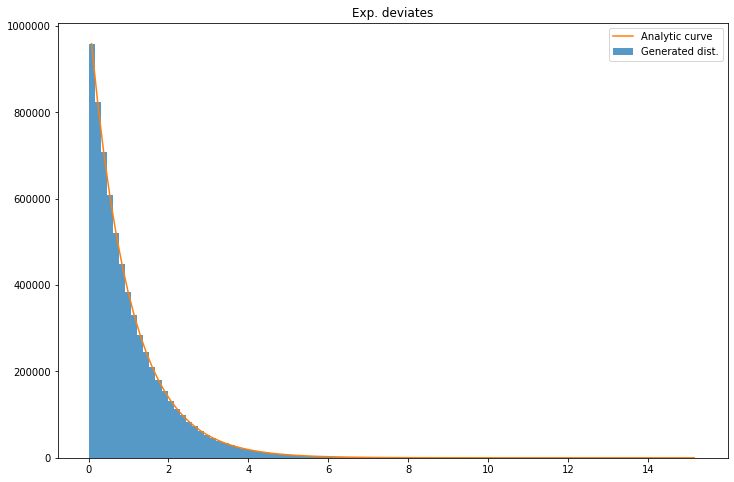

Efficiency:  33.962795 %


In [66]:
plt.figure(figsize = (12,8))
plt.title('Exp. deviates')
n,bins,patches = plt.hist(exp_dev2,100,alpha=0.75,label='Generated dist.')
bins = np.asarray(bins)
bins2 = 0.5*(bins[:-1]+bins[1:])
plt.plot(bins2,n.max()*np.exp(-(bins[:-1])),label='Analytic curve')
plt.legend()
plt.show()

print('Efficiency: ',100*len(exp_dev2)/(2*m),'%')

# This method also gives a distribution that follows closely with the curve but 
# costs more in terms of efficiency as we require twice the number of uniform deviates.

This method also serve as an good generator  for exp. deviates but the efficiency isn't as good because we require **2 uniform deviates per exponential deviate**.

But the true power of the method lies in the fact that it doesnt require a bunding function.